# Connectome-based Predictive Modeling (CPM) Approach to Identify Brain Connectivity Predictive of Liking and Wanting 
CPM is a data-driven protocol for building predictive models of brain-behavior relationships from connectivity data using cross-validation.  

Our behavioral measures of interest here are **ratings of tastant liking and wanting.**    

We run CPM analysis on n=115 subjects from the Chocolate Milkshake dataset.


In [1]:
#!conda install -c anaconda seaborn -y

In [68]:
import glob, os
import pandas as pd
import scipy as sp
import numpy as np
from nilearn.plotting import plot_connectome
from IPython.core import display as ICD
from matplotlib import pyplot as plt
%matplotlib inline

In [69]:
print("[INFO] setting folder paths")
study_path='/projects/niblab/experiments/chocolate_milkshake'
preproc_path=os.path.join(study_path,'data/preprocessed')

[INFO] setting folder paths


**CPM Functions**

## Prepare Input

* functional connectivity matrices  
* behavioral *.csv* file  
* list of subject ids

In [31]:
subject_ids=[x.split("/")[-2] for x in glob.glob(os.path.join(preproc_path, 'sub-*/ses-1'))]
#print(subject_ids[-6:])



### Functional Connectivity Matrix  
Here we grab the functional connectivity matrices (fcms) for each subject. We will create a dictionary to hold our data. 

In [33]:
data_dict={}
fc_data_path=os.path.join(study_path, 'data/bigbrain300/fc_data')
fcms_list = glob.glob(os.path.join(fc_data_path, "matrices/*avg.txt"))
subject_ids=[z.split('/')[-1].split("_")[0] for z in fcms_list]
print('[INFO] %s subject averaged matrices found \n%s'%(len(subject_ids), subject_ids))

for file in fcms_list:
    subj_id=file.split('/')[-1].split("_")[0]
    if subj_id not in data_dict:
        data_dict[subj_id]={
            "FCM": file
        }
        
        

[INFO] 72 subject averaged matrices found 
['sub-001', 'sub-004', 'sub-005', 'sub-009', 'sub-011', 'sub-015', 'sub-020', 'sub-022', 'sub-027', 'sub-028', 'sub-029', 'sub-030', 'sub-032', 'sub-037', 'sub-038', 'sub-039', 'sub-040', 'sub-041', 'sub-042', 'sub-046', 'sub-047', 'sub-048', 'sub-049', 'sub-051', 'sub-055', 'sub-056', 'sub-057', 'sub-058', 'sub-060', 'sub-064', 'sub-065', 'sub-066', 'sub-068', 'sub-069', 'sub-075', 'sub-076', 'sub-077', 'sub-079', 'sub-080', 'sub-081', 'sub-085', 'sub-088', 'sub-089', 'sub-092', 'sub-093', 'sub-097', 'sub-098', 'sub-099', 'sub-100', 'sub-101', 'sub-102', 'sub-106', 'sub-107', 'sub-108', 'sub-109', 'sub-110', 'sub-115', 'sub-116', 'sub-117', 'sub-118', 'sub-119', 'sub-126', 'sub-128', 'sub-130', 'sub-131', 'sub-132', 'sub-138', 'sub-142', 'sub-143', 'sub-144', 'sub-146', 'sub-147']


In [34]:
# check data dictionary
# add better inspection
data_dict

{'sub-001': {'FCM': '/projects/niblab/experiments/chocolate_milkshake/data/bigbrain300/fc_data/matrices/sub-001_ses-1_task-milkshakeC-milkshakeB_avg.txt'},
 'sub-004': {'FCM': '/projects/niblab/experiments/chocolate_milkshake/data/bigbrain300/fc_data/matrices/sub-004_ses-1_task-milkshakeB-milkshakeA_avg.txt'},
 'sub-005': {'FCM': '/projects/niblab/experiments/chocolate_milkshake/data/bigbrain300/fc_data/matrices/sub-005_ses-1_task-milkshakeC-milkshakeB_avg.txt'},
 'sub-009': {'FCM': '/projects/niblab/experiments/chocolate_milkshake/data/bigbrain300/fc_data/matrices/sub-009_ses-1_task-milkshakeD-milkshakeB_avg.txt'},
 'sub-011': {'FCM': '/projects/niblab/experiments/chocolate_milkshake/data/bigbrain300/fc_data/matrices/sub-011_ses-1_task-milkshakeB-milkshakeA_avg.txt'},
 'sub-015': {'FCM': '/projects/niblab/experiments/chocolate_milkshake/data/bigbrain300/fc_data/matrices/sub-015_ses-1_task-milkshakeA-milkshakeC_avg.txt'},
 'sub-020': {'FCM': '/projects/niblab/experiments/chocolate_milk

### Behavioral Data  

Loading in *.csv* file. 
* Make sure the index colum uses the prefix "sub-0" and rename to "subject". 
* The ids not found in the subject list are dropped from behavioral, and NaN values are filled with 0.

In [35]:
# load behavioral data into a pandas dataframe
behavioral_file='/projects/niblab/experiments/chocolate_milkshake/data/behavioral/behavioral_wave1.csv'
behavioral=pd.read_csv(behavioral_file)#, index_col="ID")

print("\n[INFO] original dataframe load: \n")
ICD.display(behavioral.tail())



[INFO] original dataframe load: 



,ID,Scan Date,Scan time,Ate (hrs),Hunger,Snack,"Sex (1=m, 2=f)",Protocol #,Paradigm 1,Paradigm 2,Paradigm 3,Paradigm 4,Paradigm 5,Paradigm 6,Paradigm 7,Notes:
149,150,10/1/2013,14:00,3.00,5.0,0.0,1.0,3.0,local field map,imagine,milkB,milkC,GNG1,GNG2,rage,NaN
150,151,10/4/2013,12:09,13.00,6.0,0.0,2.0,4.0,local field map,milkC,milkB,imagine,GNG2,GNG1,rage,NaN
151,152,9/29/2013,15:01,3.00,10.0,1.0,1.0,2.0,local field map,milkB,milkA,GNG2,GNG1,imagine,rage,Participant said head was uncomfortable before...
152,153,10/13/2013,16:30,5.50,2.0,0.0,2.0,12.0,local field map,milkD,milkA,imagine,GNG2,GNG1,rage,NaN
153,154,10/6/2013,14:35,5.25,7.0,0.0,2.0,9.0,local field map,imagine,milkC,milkA,GNG1,GNG2,rage,"""Water temp too hot""error- Bill said everythin..."


In [36]:
# reformat id in index to match the subject ids
for id_num in behavioral['ID']:
    new_value='sub-%03d'%id_num
    #print(new_value)
    # replace original ID value with new value
    #print(new_value,behavioral.iloc[id_num-1, behavioral.columns.get_loc('ID')])
    behavioral.iloc[id_num-1, behavioral.columns.get_loc('ID')]=new_value
    
    
# drop subject rows that don't have matrices available
#df_behavioral.head()


In [37]:
# set index to the ID column and rename it
behavioral.set_index("ID", inplace=True)
behavioral.index.name="subject"

print("\n[INFO] reformatted dataframe: \n")


behavioral.head()


[INFO] reformatted dataframe: 



,Scan Date,Scan time,Ate (hrs),Hunger,Snack,"Sex (1=m, 2=f)",Protocol #,Paradigm 1,Paradigm 2,Paradigm 3,Paradigm 4,Paradigm 5,Paradigm 6,Paradigm 7,Notes:
subject,,,,,,,,,,,,,,,
sub-001,8/4/2012,12:03,2.0,6.0,0.0,1.0,3.0,local field map,imagine,milkB,milkC,GNG1,GNG2,rage,NaN
sub-002,6/29/2012,13:30,4.0,4.0,0.0,1.0,999.0,local field map,milkA,milkB,rage,imagine,GNG1,GNG2,NaN
sub-003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub-004,30-Jul,15:13,999.0,7.0,0.0,2.0,1.0,local field map,milkA,milkB,imagine,GNG1,GNG2,rage,NaN
sub-005,8/5/2012,10:05,8.0,7.0,0.0,1.0,4.0,local field map,milkC,milkB,imagine,GNG2,GNG1,rage,NaN


In [38]:
# some of the subjects in our csv file are not included in this subject set,
# we need to drop those subjects(rows) from the csv file to continue

# gathering the subjects to drop
drop_list=[x for x in behavioral.index.values if x not in subject_ids]

print('\n[INFO]\tdropping %s subjects \n\tfcm subject count: %s \tsubjects found: %s'%(len(drop_list), 
                                                                                       len(subject_ids), len(behavioral.index.values)))






[INFO]	dropping 82 subjects 
	fcm subject count: 72 	subjects found: 154


In [39]:
# drop subjects from behavioral dataframe
behavioral.drop(drop_list,axis=0,inplace=True)

In [40]:
#behavioral.index.values

## Choose Behavioral Measure

In [41]:

print('[INFO] column values: \n', behavioral.columns.values)
ICD.display(behavioral.head())

[INFO] column values: 
 ['Scan Date' 'Scan time' 'Ate (hrs)' 'Hunger' 'Snack' 'Sex (1=m, 2=f)'
 'Protocol #' 'Paradigm 1' 'Paradigm 2' 'Paradigm 3' 'Paradigm 4'
 'Paradigm 5' 'Paradigm 6' 'Paradigm 7' 'Notes:']


,Scan Date,Scan time,Ate (hrs),Hunger,Snack,"Sex (1=m, 2=f)",Protocol #,Paradigm 1,Paradigm 2,Paradigm 3,Paradigm 4,Paradigm 5,Paradigm 6,Paradigm 7,Notes:
subject,,,,,,,,,,,,,,,
sub-001,8/4/2012,12:03,2.0,6.0,0.0,1.0,3.0,local field map,imagine,milkB,milkC,GNG1,GNG2,rage,NaN
sub-004,30-Jul,15:13,999.0,7.0,0.0,2.0,1.0,local field map,milkA,milkB,imagine,GNG1,GNG2,rage,NaN
sub-005,8/5/2012,10:05,8.0,7.0,0.0,1.0,4.0,local field map,milkC,milkB,imagine,GNG2,GNG1,rage,NaN
sub-009,8/5/2012,12:00,12.0,4.0,0.0,1.0,5.0,local field map,GNG1,GNG2,milkB,milkD,imagine,rage,NaN
sub-011,8/1/2012,12:28,14.0,5.0,0.0,2.0,2.0,local field map,milkB,milkA,GNG2,GNG1,imagine,rage,"participant moved legs in between scans, but s..."


In [42]:
import seaborn as sns


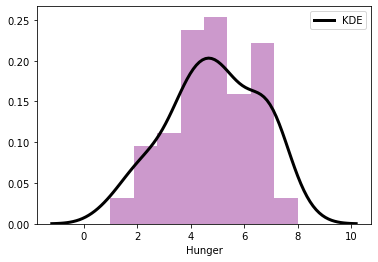

In [45]:
behav_measure = 'Hunger'
sns.distplot(behavioral[behav_measure], color="purple",kde_kws={"color": "k", "lw": 3, "label": "KDE"})
#plt.show()


Data distribution looks heavily distributed with males,   
use partial correlation?

## Run CPM

In [70]:

def plot_consistent_edges(all_masks, roi_coords, tail, thresh = 1., color='gray'):
    
    edge_frac = (all_masks[tail].sum(axis=0))/(all_masks[tail].shape[0])
    edge_frac_square = sp.spatial.distance.squareform(edge_frac)

    node_mask = np.amax(edge_frac_square, axis=0) >= thresh # find nodes that have at least one edge that passes the threshold
    node_size = edge_frac_square.sum(axis=0)*node_mask*20 # size nodes based on how many suprathreshold edges they have

    plot_connectome(adjacency_matrix=edge_frac_square, edge_threshold=thresh,
                    node_color = color,title=tail, node_coords=roi_coords, node_size=node_size,
                    display_mode= 'lzry',
                    edge_kwargs={"linewidth": 1, 'color': color})
    print("For the {} tail, {} edges were selected in at least {}% of folds".format(tail, (edge_frac>=thresh).sum(), thresh*100))
    
    

#####################################################################################################################


def plot_predictions(behav_obs_pred,color, behav, tail="glm"):
    x = behav_obs_pred.filter(regex=("obs")).astype(float)
    y = behav_obs_pred.filter(regex=(tail)).astype(float)

    g = sns.regplot(x=x.T.squeeze(), y=y.T.squeeze(), color=color)
    ax_min = min(min(g.get_xlim()), min(g.get_ylim()))
    ax_max = max(max(g.get_xlim()), max(g.get_ylim()))
    g.set_xlim(ax_min, ax_max)
    g.set_ylim(ax_min, ax_max)
    g.set_aspect('equal', adjustable='box')

    #print(y.columns.values)
    r = sp.stats.pearsonr(x['%s observed'%behav],y['%s predicted (glm)'%behav])
    r_value = r[0]
    p_value = r[1]
    g.annotate('r = {0:.2f}'.format(r_value), xy = (0.7, 0.9), xycoords = 'axes fraction')
    
    return g

#####################################################################################################################

def build_model(train_vcts, mask_dict, train_behav):
    """
    Builds a CPM model:
    - takes a feature mask, sums all edges in the mask for each subject, and uses simple linear regression to relate summed network strength to behavior
    """

    assert train_vcts.index.equals(train_behav.index), "[ERROR FOUND] Row indices of FC vcts and behavior don't match!"

    model_dict = {}

    # Loop through pos and neg tails
    X_glm = np.zeros((train_vcts.shape[0], len(mask_dict.items())))

    t = 0
    for tail, mask in mask_dict.items():
        X = train_vcts.values[:, mask].sum(axis=1)
        X_glm[:, t] = X
        y = train_behav
        
        (slope, intercept) = np.polyfit(X, y, 1)
        model_dict[tail] = (slope, intercept)
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    model_dict["glm"] = tuple(np.linalg.lstsq(X_glm, y, rcond=None)[0])

    return model_dict

#####################################################################################################################

def apply_model(test_vcts, mask_dict, model_dict):
    """
    Applies a previously trained linear regression model to a test set to generate predictions of behavior.
    """

    behav_pred = {}

    X_glm = np.zeros((test_vcts.shape[0], len(mask_dict.items())))

    # Loop through pos and neg tails
    t = 0
    for tail, mask in mask_dict.items():
        #print(tail, mask)
        X = test_vcts.loc[:, mask].sum(axis=1)
        X_glm[:, t] = X

        slope, intercept = model_dict[tail]
        behav_pred[tail] = slope*X + intercept
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    behav_pred["glm"] = np.dot(X_glm, model_dict["glm"])

    return behav_pred


#####################################################################################################################

def select_features(train_vcts, train_behav, r_thresh=0.2, corr_type='pearson', verbose=False):
    
    """
    Runs the CPM feature selection step: 
    - correlates each edge with behavior, and returns a mask of edges that are correlated above some threshold, one for each tail (positive and negative)
    """

    assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"

    # Correlate all edges with behav vector
    if corr_type =='pearson':
        cov = np.dot(train_behav.T - train_behav.mean(), train_vcts - train_vcts.mean(axis=0)) / (train_behav.shape[0]-1)
        corr = cov / np.sqrt(np.var(train_behav, ddof=1) * np.var(train_vcts, axis=0, ddof=1))
    elif corr_type =='spearman':
        corr = []
        for edge in train_vcts.columns:
            r_val = sp.stats.spearmanr(train_vcts.loc[:,edge], train_behav)[0]
            corr.append(r_val)

    # Define positive and negative masks
    mask_dict = {}
    mask_dict["pos"] = corr > r_thresh
    mask_dict["neg"] = corr < -r_thresh
    
    if verbose:
        print("Found ({}/{}) edges positively/negatively correlated with behavior in the training set".format(mask_dict["pos"].sum(), mask_dict["neg"].sum())) # for debugging

    return mask_dict

#####################################################################################################################

def get_train_test_data(all_fc_data, train_subs, test_subs, behav_data, behav):

    """
    Extracts requested FC and behavioral data for a list of train_subs and test_subs
    """

    train_vcts = all_fc_data.loc[train_subs, :]
    test_vcts = all_fc_data.loc[test_subs, :]

    train_behav = behav_data.loc[train_subs, behav]

    return (train_vcts, train_behav, test_vcts)

#####################################################################################################################


def split_train_test(subj_list, indices, test_fold):
    """
    For a subj list, k-fold indices, and given fold, returns lists of train_subs and test_subs
    """

    train_inds = np.where(indices!=test_fold)
    test_inds = np.where(indices==test_fold)

    train_subs = []
    for sub in subj_list[train_inds]:
        train_subs.append(sub)

    test_subs = []
    for sub in subj_list[test_inds]:
        test_subs.append(sub)

    return (train_subs, test_subs)

#####################################################################################################################


def mk_kfold_indices(subj_list, k):
    """
    Splits list of subjects into k folds for cross-validation.
    """
    
    n_subs = len(subj_list)
    n_subs_per_fold = n_subs//k # floor integer for n_subs_per_fold

    indices = [[fold_no]*n_subs_per_fold for fold_no in range(k)] # generate repmat list of indices
    remainder = n_subs % k # figure out how many subs are left over
    remainder_inds = list(range(remainder))
    indices = [item for sublist in indices for item in sublist]    
    [indices.append(ind) for ind in remainder_inds] # add indices for remainder subs

    assert len(indices)==n_subs, "Length of indices list does not equal number of subjects, something went wrong"

    np.random.shuffle(indices) # shuffles in place

    return np.array(indices)


#####################################################################################################################


def cpm_wrapper(all_fc_data, all_behav_data,condition, behav,  k, **cpm_kwargs):

    assert all_fc_data.index.equals(all_behav_data.index), "Row (subject) indices of FC vcts and behavior don't match!"

    subj_list = all_fc_data.index # get subj_list from df index
    
    indices = mk_kfold_indices(subj_list, k)
    
    # Initialize df for storing observed and predicted behavior
    col_list = []
    for tail in ["pos", "neg", "glm"]:
        col_list.append(behav + " predicted (" + tail + ")")
    col_list.append(behav + " observed")
    behav_obs_pred = pd.DataFrame(index=subj_list, columns = col_list)
    
    
    # Initialize array for storing feature masks
    n_edges = all_fc_data.shape[1]
    all_masks = {}
    all_masks["pos"] = np.zeros((k, n_edges))
    all_masks["neg"] = np.zeros((k, n_edges))
    
    for fold in range(k):
        #print("[INFO] doing fold {}".format(fold))
        train_subs, test_subs = split_train_test(subj_list, indices, test_fold=fold)
        train_vcts, train_behav, test_vcts = get_train_test_data(all_fc_data, train_subs, test_subs, all_behav_data, behav=behav)
        mask_dict = select_features(train_vcts, train_behav, **cpm_kwargs)
        all_masks["pos"][fold,:] = mask_dict["pos"]
        all_masks["neg"][fold,:] = mask_dict["neg"]
        try:
            model_dict = build_model(train_vcts, mask_dict, train_behav)
          #print(model_dict.keys())
          #print("[INFO] model building complete.")
        except Exception as e:
            print("[ERROR FOUND] {} \n".format(e))
        try:
            behav_pred = apply_model(test_vcts, mask_dict, model_dict)
            print("[INFO] glm applied, behavior predicted with test set.")
        except Exception as e:
            print("[ERROR FOUND] {} \n".format(e))
        
        for tail, predictions in behav_pred.items():
            behav_obs_pred.loc[test_subs, behav + " predicted (" + tail + ")"] = predictions
            
    behav_obs_pred.loc[subj_list, behav + " observed"] = all_behav_data[behav]
    
    if not behav_obs_pred.empty: print('[INFO] CPM completed with %s folds.'%(k))
    return behav_obs_pred, all_masks


#####################################################################################################################

def read_in_matrices(data_dict, file_suffix=None, zscore=False):#, data_dir=data_dir, zscore=False):
    """
    Reads in a set of individual-subject connectivity matrices stored in data_dir,

    Returns a dataframe that is subjects x edges (by vectorizing the upper triangle of each FC matrix).

    Assumes:
    - each matrix is stored in a separate file beginning with the subject ID, and
    - matrices are symmetric (squareform); i.e., for a parcellation with 268 nodes, matrices should be 268 x 268
    """

    all_fc_data = {}

    for subj in data_dict.keys():
        # load this subject's matrix
        matrix_file=data_dict[subj]["FCM"]
        matrix=np.loadtxt(matrix_file)
            #if file_suffix:
              # make list files found
              #matrix = fc_corr_dict[subj][file_suffix]
            #file = [f for f in matrices if subj in f and file_suffix in f]
        #else:
            #file = [f for f in matrices if subj in f]
#        except:
 #           pass    
        # make sure there is one and only one file    
        #if len(file) ==0:
            #raise ValueError("No data found for subject {}".format(subj))
        #if len(file) >1:
            #raise ValueError("More than one matrix found for subject {}! Specify a suffix?".format(subj))

        # read it in and make sure it's symmetric and has reasonable dimensions
        tmp = matrix.reshape(300,-1)#.transpose(2,0,1).reshape(300,-1)

        assert tmp.shape[0]==tmp.shape[1]>1, "Matrix seems to have incorrect dimensions: {}".format(tmp.shape)

        # take just the upper triangle and store it in a dictionary
        if ~zscore:
            all_fc_data[subj] = tmp[np.triu_indices_from(tmp, k=1)]
        if zscore:
            all_fc_data[subj] = sp.stats.zscore(tmp[np.triu_indices_from(tmp, k=1)])

    # Convert dictionary into dataframe
    all_fc_data = pd.DataFrame.from_dict(all_fc_data, orient='index')
    #print('[INFO] made functional connectivity matrix dataframe.')"""


    return all_fc_data

#####################################################################################################################

def cpmPipeline(behavioral, data_dict, behav, cpm_kwargs, k=5):#cmap,condition, behav, matrices_path, cpm_kwargs, behavioral,cond_color,k):
    # first step compute timeseries matrix
    #timeseries_matrices=glob.glob(os.path.join(matrices_path, "*.txt"))
    #fc_corr_dict,subj_list=makeFCM(cmap, timeseries_matrices, file_suffix=condition, functionals=None)
    
    
    
    # make functional connectivity matrix of all subjects
    all_fc_data = read_in_matrices(data_dict)#, file_suffix=condition)
    
    #print(all_fc_data)
    # replace infinite values with nan
    all_fc_data.replace([np.inf, -np.inf], np.nan)
    # fill nan values with column average
    all_fc_data.fillna(all_fc_data.mean(axis=1), inplace=True)

    # run cpm
    behav_obs_pred, all_masks = cpm_wrapper(all_fc_data, behavioral, "milkshake", behav,k, **cpm_kwargs)

    print("\n")
    ICD.display(behav_obs_pred.head())
    # plot scatter plot
    print('\nPlot of Observed vs. Predicted Behavior \n')
    g = plot_predictions(behav_obs_pred,cond_color, behav)
    g.set_title(condition.upper())
    plt.show()

    print("\n\n\n")

    roi_coords=pd.read_csv('/projects/niblab/parcellations/bigbrain300/BigBrain300_MNI_coordinates.txt', header=None,sep='\t')
    #ICD.display(roi_coords.head())
    plot_consistent_edges(all_masks, roi_coords, "pos", thresh = 0.8, color = 'deeppink')
    plot_consistent_edges(all_masks, roi_coords, "neg", thresh = 0.8, color = 'purple')


In [71]:
def main(condition, behav, cond_color,matrices_path,cmap, k):
    #setup input parameters 
    matrices_path='/content'
    cpm_kwargs = {'r_thresh': 0.2, 'corr_type': 'pearson'} # these are the defaults, but it's still good to be explicit
    #run pipeline
    cpmPipeline(behavioral, data_dict, behav, cpm_kwargs)#cmap,condition, behav, matrices_path, cpm_kwargs, behavioral, cond_color,k)

[INFO] glm applied, behavior predicted with test set.
[INFO] glm applied, behavior predicted with test set.
[INFO] glm applied, behavior predicted with test set.
[INFO] glm applied, behavior predicted with test set.
[INFO] glm applied, behavior predicted with test set.
[INFO] CPM completed with 5 folds.




,Hunger predicted (pos),Hunger predicted (neg),Hunger predicted (glm),Hunger observed
sub-001,5.61346,5.72398,6.5886,6
sub-004,4.67926,5.44847,5.38024,7
sub-005,4.98961,4.47524,4.73527,7
sub-009,4.5476,5.23775,5.03896,4
sub-011,4.09548,4.67157,3.75205,5



Plot of Observed vs. Predicted Behavior 



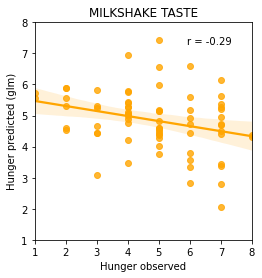

/projects/niblab/modules/software/miniconda3/miniconda3/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:71: UserWarning: The given float value must not exceed 0.6. But, you have given threshold=0.8 
  threshold))


For the pos tail, 0 edges were selected in at least 80.0% of folds
For the neg tail, 2 edges were selected in at least 80.0% of folds


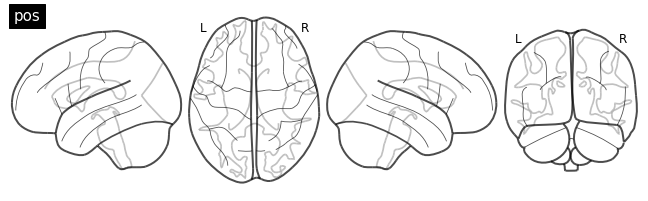

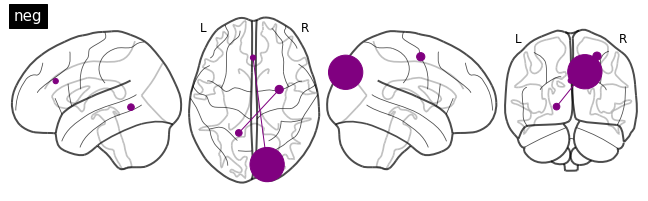

In [72]:
condition="milkshake taste"
matrices_path="/content"
behav=behav_measure
cmap="Oranges"
k=100
cond_color='orange'
main(condition, behav_measure,cond_color, matrices_path,cmap,k)